## Data Preprocessing
This notebook handles the preprocessing of the dataset that is used to train the model.
<br><br>

### __Dataset Details__
The data consists of labeled images of rocks and minerals organized by their respective types.

There are two sets of data, the [__training data__](#training-data-processing) and the [__testing data__](#test-data-processing). Each set follows the same structure outlined above, with the only difference coming from how the images are preprocessed. <br><br>

#### Resizing
Image size affects a variety of factors when it comes to training a model, but mainly __performance__ and __detail__. Due to rocks and minerals being the target of identification, i'll be training the model with an image size of __256px x 256px__. This will add more detail for the model to train on, which will hopefully translate to improved accuracy when fed sub-optimal images to identify.
<br><br>

***

### Step 1: Splitting dataset
The first step is to split the data into a set for training and a set for testing. This can be done manually, but instead I'm going to utilize scikit-learn's `train_test_split()` method with an 80/20 split (80% used for training and 20% for testing).

In [1]:
import os
from sklearn.model_selection import train_test_split

In [2]:
# Path to the dataset
dataset_path = '.\\wa_spec_dataset'

# Defining 2 arrays to eventually store image paths and labels
image_paths = []
image_labels = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    # Check if folder_path is a directory
    if os.path.isdir(folder_path):
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            class_name = os.path.basename(os.path.dirname(subfolder)).split('_')[0]

            image_paths.append(subfolder_path)
            image_labels.append(subfolder.split('_')[0])

# Using the train_test_split() method to split the data
X_train, X_test, y_train, y_test = train_test_split(image_paths, image_labels, test_size=0.2, stratify=image_labels, random_state=42)

### Step 2: Processing The Data

In [3]:
# Using PyTorch to preprocess images
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import Dataset, DataLoader

#### Defining Transformations
Below I'm defining the transformations to be applied during training, here's a breakdown of each transformation:
- __`.Resize`__ <br>
The model expects a specific size image, so this adjusts the size of each image to match.
<br><br>
- __`.RandomHorizontalFlip` & `.RandomRotation`__ <br>
Both of these functions are used to provide more variety to the small dataset, artificially 'increasing' the size.
<br><br>
- __`.ToTensor`__ <br>
Converts the image to a PyTorch tensor (a multi-dimensional array), scaling the pixel values to a range between 0 and 1 for easier manipulation.
<br><br>
- __`.Normalize`__ <br>
Further scales the pixel values based on the set mean and standard deviation ((val - mean) / standard deviation).

In [4]:
# Const variable for image size
IMAGE_SIZE = 256

processed_training_data = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Essentially the same, but without the augmentation
processed_test_data = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#### Using DataLoader
DataLoader provides efficient management of the datatset, batch sizes, continuous transformations, shuffling and more. 
- __Batch Sizes__: <br> 
Allows the model to process multiple images at once rather than one by one.
<br><br>
- __Continuous Transformations__: <br>
Upon each epoch, the transformations we defined above will be reapplied to each image meaning the model will be seeing the same images but with slight variation each time.
<br><br>
- __Shuffling__: <br>
Exactly as it sounds, the data is shuffled each time.

In [5]:
# Const variable for batch size
BATCH_SIZE = 10

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Creating dataset instances, using the appropriate transformations defined above.
train_dataset = CustomDataset(X_train, y_train, transform = processed_training_data)
test_dataset = CustomDataset(X_test, y_test, transform = processed_test_data)


# Creating seperate data loaders for training and testing data
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Model, Loss Function & Optimizer
- __Model__: <br>
Convolutional Neural Network
<br><br>
- __Loss Function__: <br>
Cross Entropy Loss is best suited for classification tasks, in short it penalizes the model based on it's confidence when making both corrent and incorrect predictions.
<br><br>
- __Optimizer__: <br>
Based on what I've read, `Adam` seems to be the recommended optimizer for classification tasks. However, due to my dataset being limited, another option I'm going to explore is `Adagrad`.


In [46]:
# Importing the cnn
from rockhound_cnn import RockHoundCNN
import torch
import torch.nn as nn
import torch.optim as optim

LEARNING_RATE = 0.001

# Initialize model, loss function, and optimizer
num_classes = len(set(image_labels))
model = RockHoundCNN(num_classes)

# loss function (predicted vs actual)
lossFunc = nn.CrossEntropyLoss()

# Going to test multiple optimizers
# Adam, Adagrad
optimizer_adam = optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer_adagrad = optim.Adagrad(model.parameters(), lr=0.001, lr_decay=0, weight_decay=0)

# Move model to GPU if available
# Improves performance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RockHoundCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
from early_stopping import EarlyStopping

# Create a label mapping
label_map = {'chalcedony': 0, 'jasper': 1, 'petrifiedwood': 2, 'quartz': 3}

# Num of runs through training data
num_epochs = 1000

early_stopping = EarlyStopping(patience=5, delta=0.005)
train_loss_data = []
val_loss_data = []

for epoch in range(num_epochs):

    model.train()  
    training_loss = 0
    for data in train_loader:
        images = data[0].to(device)

        # Convert labels to numeric using the label mapping
        # important for loss function
        numeric_labels = [label_map[label] for label in data[1]] 
        labels = torch.tensor(numeric_labels, dtype=torch.long).to(device)
        
        optimizer_adam.zero_grad()
        outputs = model(images)
        loss = lossFunc(outputs, labels)
        loss.backward()
        optimizer_adam.step()
        
        training_loss += loss.item()

    training_loss /= len(train_loader)
    train_loss_data.append(loss.item())

    model.eval()
    validation_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0].to(device)  # Move images to the device
            
            # Convert labels to numeric using the label mapping
            # Assuming data[1] is a list of labels
            numeric_labels = [label_map[label] for label in data[1]]
            labels = torch.tensor(numeric_labels, dtype=torch.long).to(device)

            outputs = model(images)
            loss = lossFunc(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validation_loss /= len(test_loader)
    val_loss_data.append(loss.item())

    early_stopping(training_loss ,model)

    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break
    

    # Print loss for each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")
    
# Print the accuracy
accuracy = 100 * correct / total if total > 0 else 0  # Avoid division by zero
print(f'Test data model accuracy: {accuracy:.2f}%')

Epoch [1/1000], Training Loss: 5.1087, Validation Loss: 2.7297
Epoch [2/1000], Training Loss: 1.7933, Validation Loss: 2.6030
Epoch [3/1000], Training Loss: 1.2602, Validation Loss: 2.0536
Epoch [4/1000], Training Loss: 0.6232, Validation Loss: 0.6983
Epoch [5/1000], Training Loss: 0.3982, Validation Loss: 0.6960
Epoch [6/1000], Training Loss: 0.4006, Validation Loss: 0.7490
Epoch [7/1000], Training Loss: 0.1323, Validation Loss: 0.9156
Epoch [8/1000], Training Loss: 0.1488, Validation Loss: 1.4291
Epoch [9/1000], Training Loss: 0.0536, Validation Loss: 2.0630
Epoch [10/1000], Training Loss: 0.0253, Validation Loss: 2.3237
Epoch [11/1000], Training Loss: 0.0175, Validation Loss: 2.3470
Epoch [12/1000], Training Loss: 0.0034, Validation Loss: 2.3550
Epoch [13/1000], Training Loss: 0.0050, Validation Loss: 2.3137
Epoch [14/1000], Training Loss: 0.0020, Validation Loss: 2.2584
Epoch [15/1000], Training Loss: 0.0024, Validation Loss: 2.2015
Epoch [16/1000], Training Loss: 0.0057, Validatio

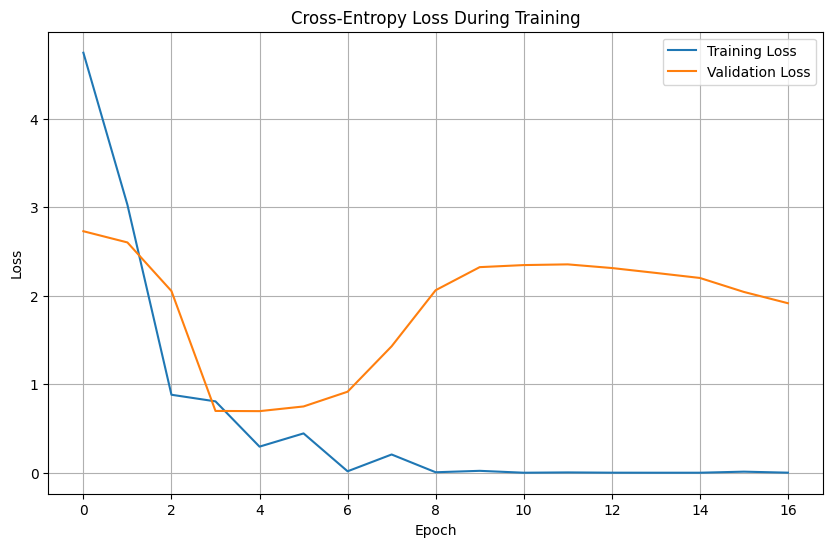

Test data model accuracy: 87.50%


In [ ]:
import matplotlib.pyplot as plt

# Plotting training loss vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_data, label='Training Loss')
plt.plot(val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross-Entropy Loss During Training')
plt.legend()
plt.grid()
plt.show()

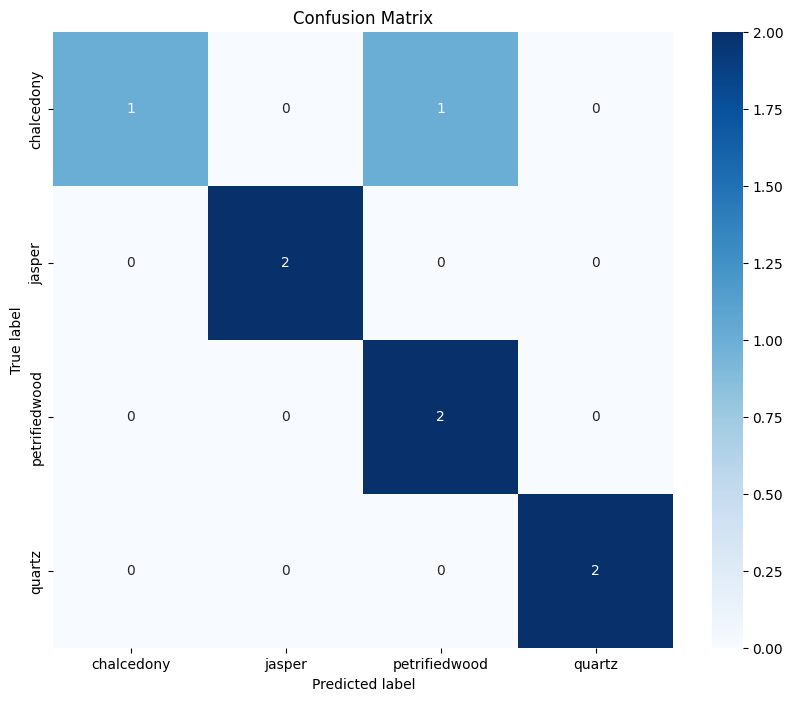

In [49]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

all_predictions = []
all_labels = []

# No gradient computation during evaluation
with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)
        labels = data[1]

        # Convert labels to indices
        numeric_labels = [label_map[label] for label in labels]
        labels_tensor = torch.tensor(numeric_labels, dtype=torch.long).to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels_tensor.cpu().numpy())


# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Class names corresponding to your labels
class_names = ['chalcedony', 'jasper', 'petrifiedwood', 'quartz']

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)



#### Breakdown of Results
- __Accuracy__: <br>
So far, the high is 75%, with an average of about 63%. The best parameters seem to be a batch size of 10, epoch of 7, and a learning rate of 0.001
    - updated results (11/18/2024): the new high is 87% after incorporating early-stopping.